In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax

2025-11-20 17:22:07.407257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
empty = ['/Users/janamac/Documents/proj1/parking/clf-data/empty']
not_empty = ['/Users/janamac/Documents/proj1/parking/clf-data/not_empty']
file_p = []
labels = []
dict_lists = [empty, not_empty]
class_labels = ['empty', 'not_empty']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [4]:
df.head()

,filepaths,labels
0,/Users/janamac/Documents/proj1/parking/clf-dat...,empty
1,/Users/janamac/Documents/proj1/parking/clf-dat...,empty
2,/Users/janamac/Documents/proj1/parking/clf-dat...,empty
3,/Users/janamac/Documents/proj1/parking/clf-dat...,empty
4,/Users/janamac/Documents/proj1/parking/clf-dat...,empty


In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(3411, 2)
(1219, 2)
(1462, 2)


In [7]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [8]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=16,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=16,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=16,
                                    shuffle=False
                                   )

Found 3409 validated image filenames belonging to 2 classes.


Found 1219 validated image filenames belonging to 2 classes.
Found 1462 validated image filenames belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/.venv/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:918: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


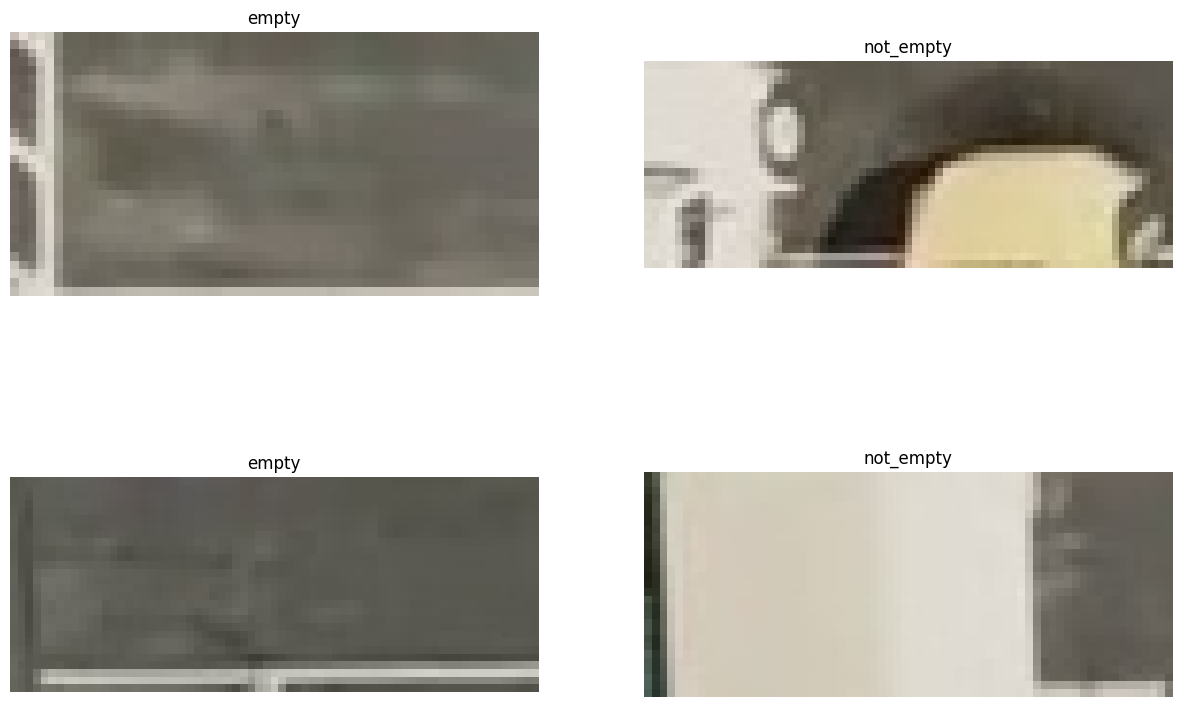

In [9]:
import matplotlib.pyplot as plt

# Define the number of images to display from each class
num_images_per_class = 2

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()


In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax

# Load InceptionV3 with pretrained weights
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='max')

# 🔒 Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Build and compile the full model
model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adamax()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (only top layers will be trained)
history = model.fit(train, epochs=10, validation_data=val)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step
Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.9111 - loss: 0.4238 - val_accuracy: 0.9877 - val_loss: 0.0428
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.9748 - loss: 0.0614 - val_accuracy: 0.9932 - val_loss: 0.0240
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.9871 - loss: 0.0372 - val_accuracy: 0.9938 - val_loss: 0.0186
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.9930 - loss: 0.0214 - val_accuracy: 0.9945 - val_loss: 0.0136
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 762s 4s/step - accuracy: 0.9953 - loss: 0.0156 - val_accuracy: 0.9952 - val_loss: 0.0106
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1043s 5s/step - accuracy: 0.9988 - loss: 0.0096 - val_accuracy: 0.9966 - val_loss: 0.0095
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 593s 3s/step - accuracy: 0.9971 - loss: 0.0086 - val_accuracy: 0.9966 - val_loss: 0.0087
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 789s

In [11]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

77/77 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 1.0000 - loss: 0.0016  
Test Loss: 0.0015966161154210567
Test Accuracy: 1.0


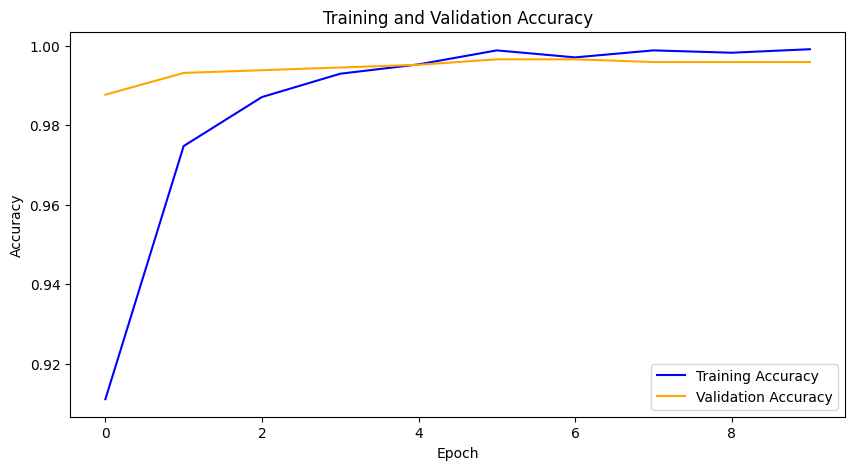

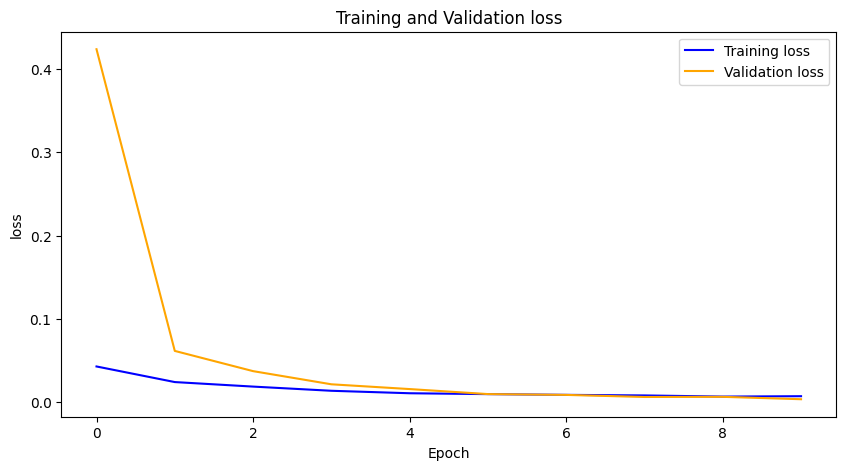

In [12]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.plot(val_loss, label='Training loss', color='blue')
plt.plot(train_loss, label='Validation loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


77/77 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step


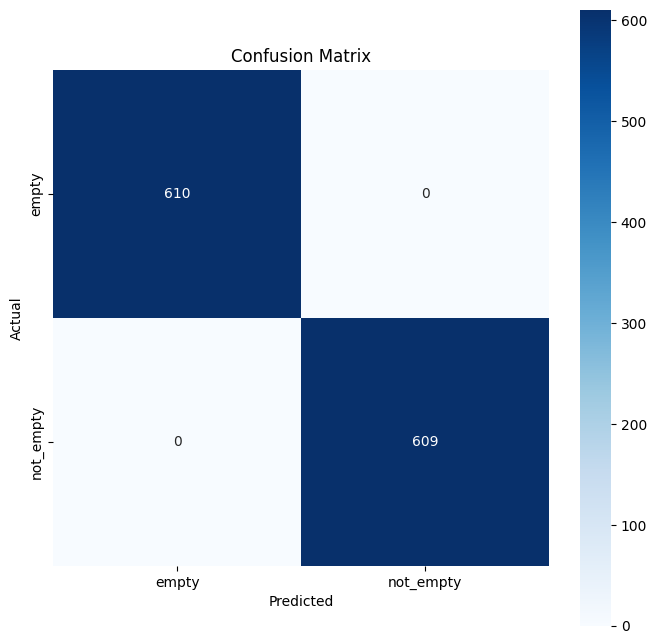

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
model.save("parking_availiablity.h5")


In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np

# دالة لتحميل صورة جديدة ومعالجتها
def prepare_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# مسار الصورة
new_image_path = "/Users/janamac/Documents/proj1/parking/clf-data/empty/00000050_00000271.jpg"

# تجهيز الصورة
img_prepared = prepare_image(new_image_path)

# التوقع
prediction = model.predict(img_prepared)

# طباعة القيمة للتأكد
print(f"prediction: {prediction}")
print(f"shape: {prediction.shape}")

# الحل الصحيح
if prediction[0][0] > 0.5:  # استخدم [0][0] بدلاً من [0]
    print("not empty")
else:
    print("empty")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
prediction: [[0.01396132 0.9860387 ]]
shape: (1, 2)
empty
